In [1]:
import os
import sys
import numpy as np
ROOT_DIR = os.path.abspath("../")
os.chdir(ROOT_DIR)
sys.path.append(ROOT_DIR)
from utils import resources
from model.model import Model
from model.model import RoofTypeConfig
from model.dataset import RoofTypeDataset

import skimage.io

import matterport.model as modellib
from matterport import visualize
from matterport.model import log
from matterport import utils
import random
import matplotlib
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [38]:
def get_ax(rows=1, cols=1, size=32):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

In [3]:
dataset_train = RoofTypeDataset()
dataset_train.load_data(os.path.join(resources.images_train_test_val, "train"))
dataset_train.prepare()

dataset_val = RoofTypeDataset()
dataset_val.load_data(os.path.join(resources.images_train_test_val, "val"))
dataset_val.prepare()

dataset_test = RoofTypeDataset()
dataset_test.load_data(os.path.join(resources.images_train_test_val, "test"))
dataset_test.prepare()

In [4]:
model = Model(mode="inference")








Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
box_ind is deprecated, use box_indices instead


Instructions for updating:
Use `tf.cast` instead.


Re-starting from epoch 250
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -127.58000  max:  224.60000  float64
image_metas              shape: (1, 19)               min:    0.00000  max:  512.00000  int32
anchors                  shape: (1, 109200, 4)        min:   -0.54233  max:    1.29184  float32


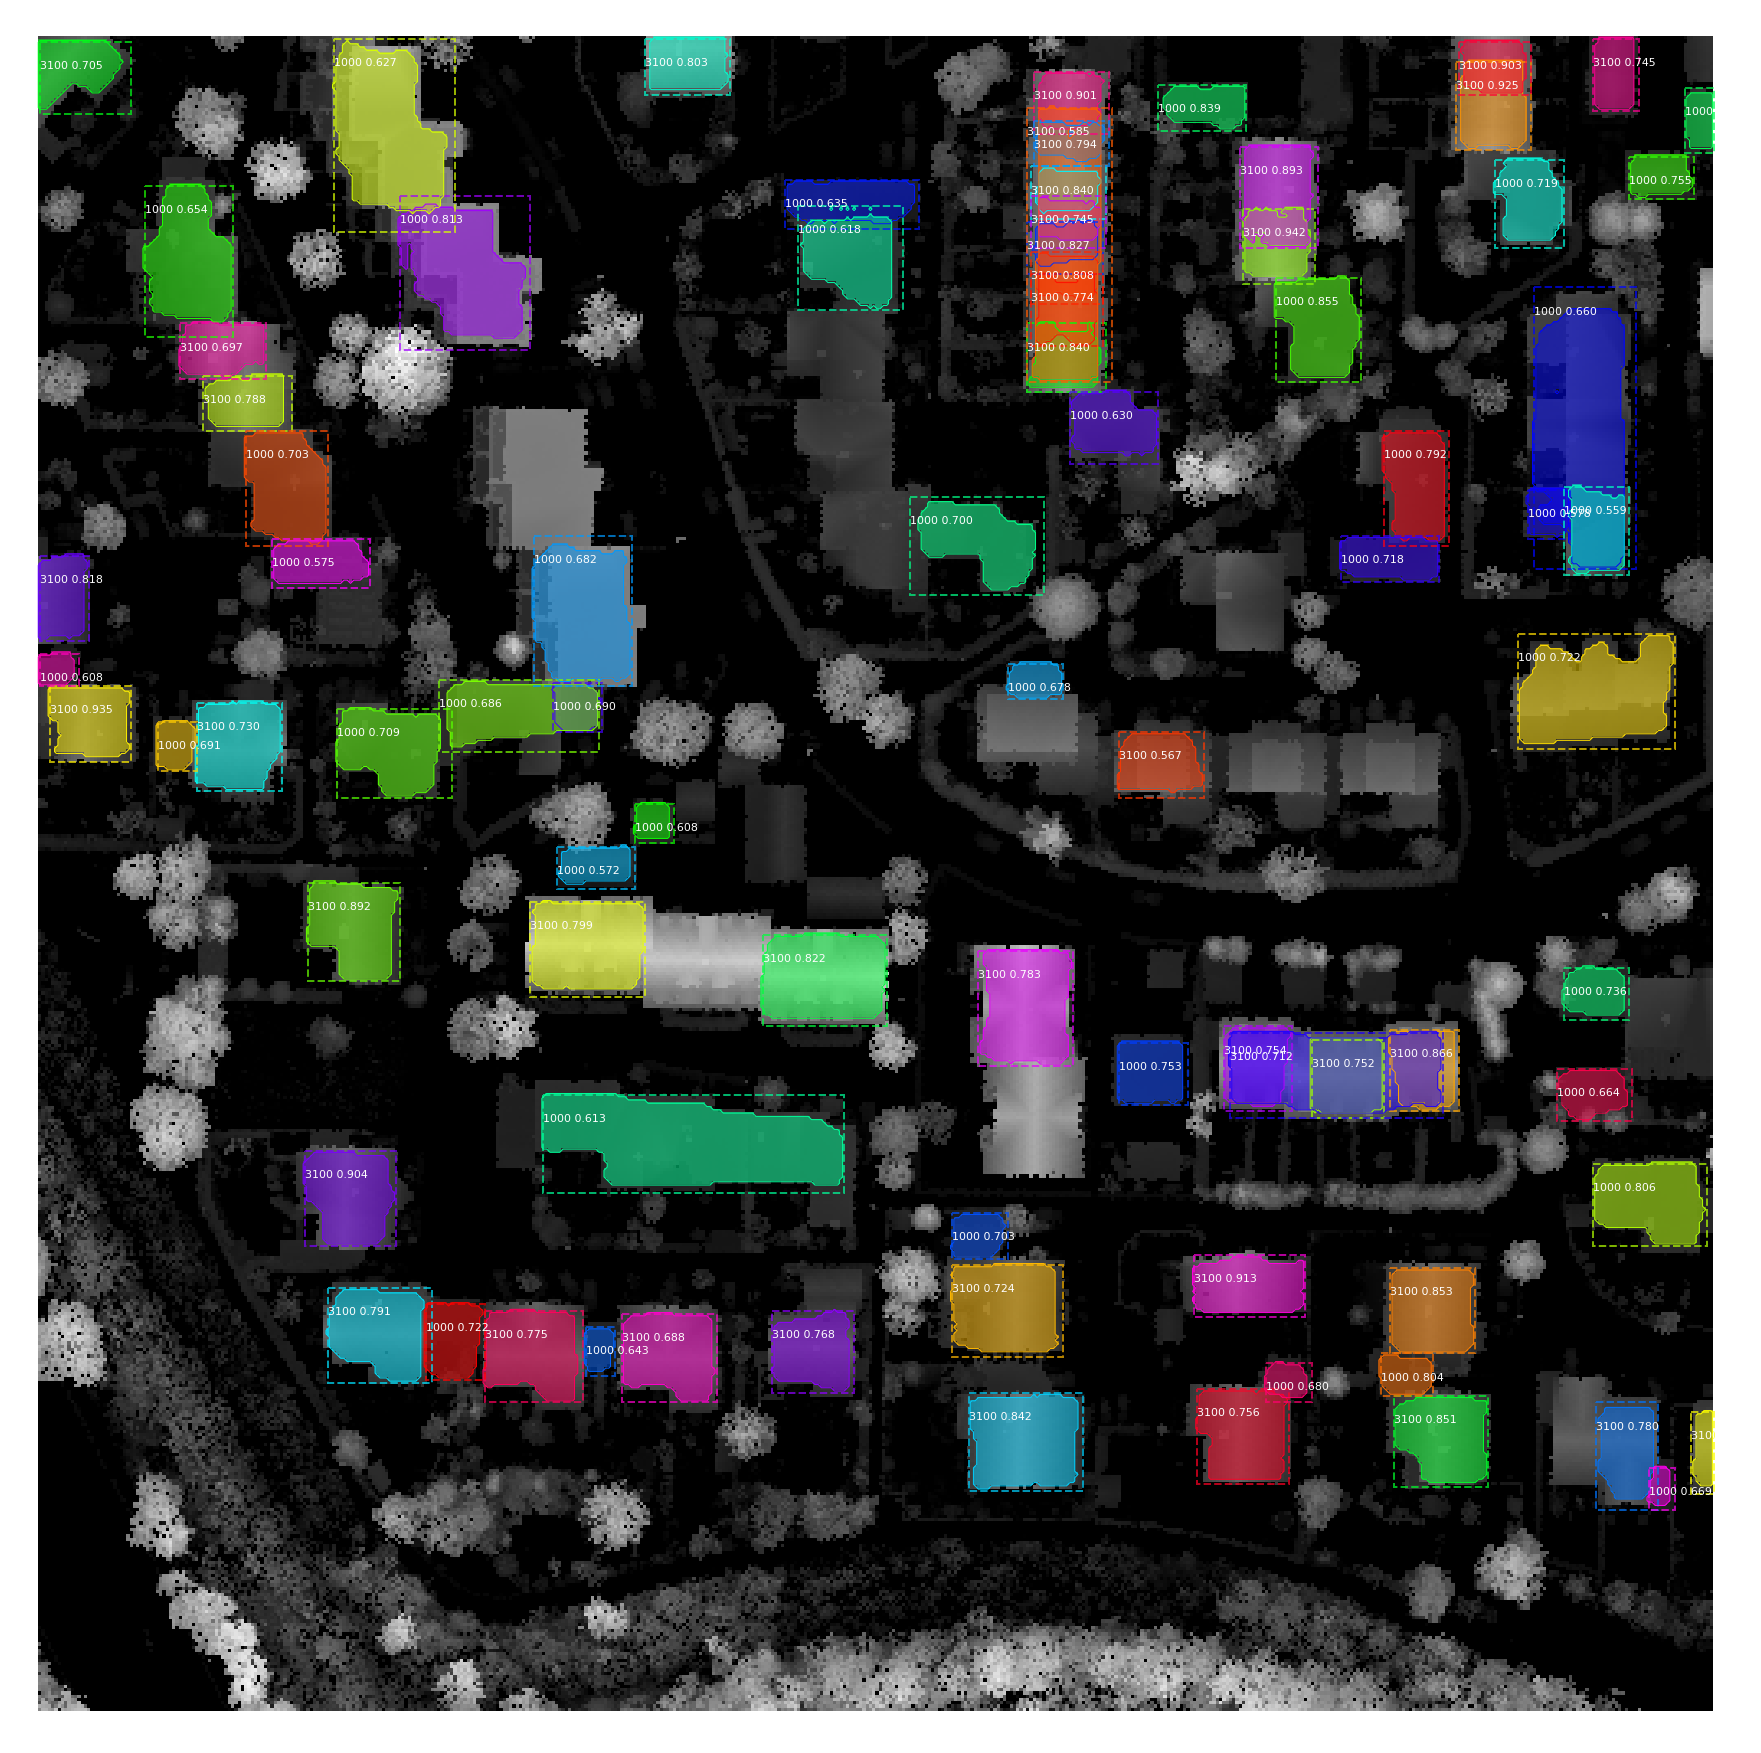

In [201]:
img_path = r"C:\Users\MoritzWollenhaupt\Desktop\paderborn\gebiete\stadt.TIF"

results = model.detect(r"C:\Users\MoritzWollenhaupt\Desktop\Masterarbeit\resources\logs2\roof_types20201009T1115\mask_rcnn_roof_types_0250.h5", [img_path])


img = skimage.io.imread(img_path)
i_min = np.min(img)
i_max = np.max(img)
i_w = i_max - i_min
img -= i_min
img *= 255. / i_w
img = img.astype(np.uint8)
img = np.dstack([img, img, img])


r = results[0][0]
visualize.display_instances(img, r['rois'], r['masks'], r['class_ids'], 
                            dataset_test.class_names, r['scores'], ax=get_ax())

original_image           shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
image_meta               shape: (19,)                 min:    0.00000  max: 5634.00000  int32
gt_class_id              shape: (15,)                 min:    1.00000  max:    3.00000  int32
gt_bbox                  shape: (15, 4)               min:    6.00000  max:  312.00000  int32
gt_mask                  shape: (512, 512, 15)        min:    0.00000  max:    1.00000  bool


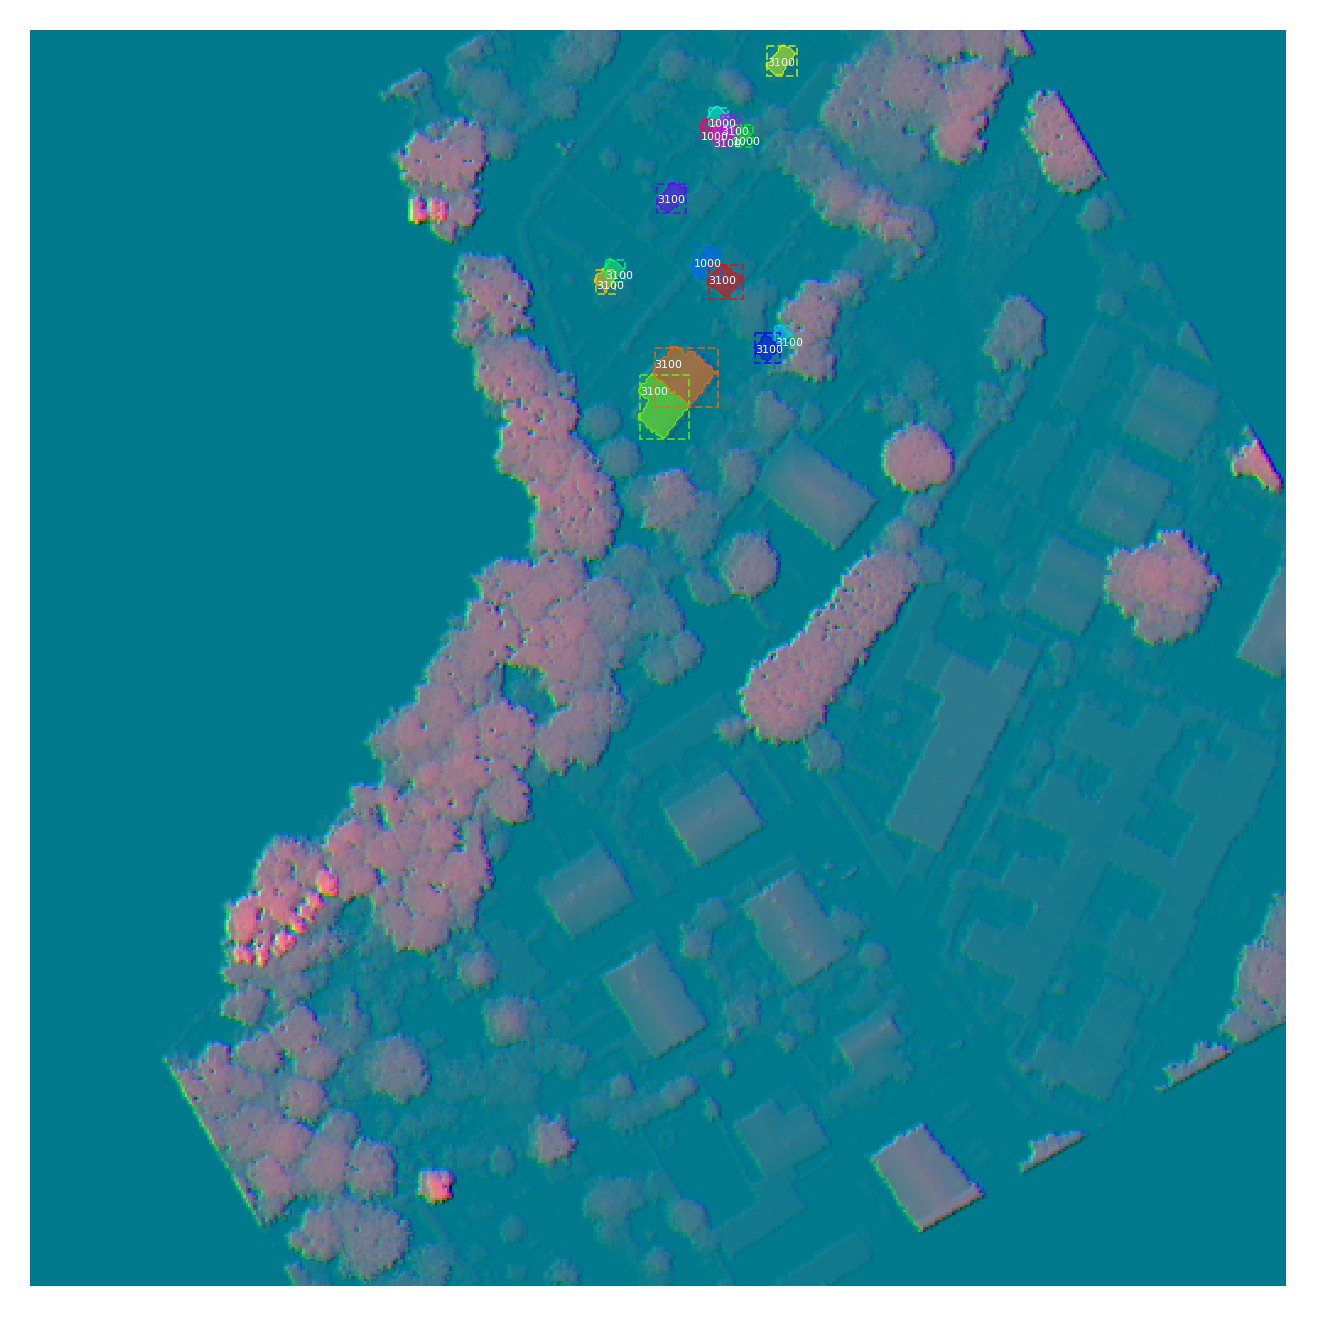

In [200]:
# Test on a random image
image_id = random.choice(dataset_test.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_test, model.config, 
                           image_id, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_train.class_names, figsize=(24, 24))

In [ ]:
path, file = os.path.split(dataset_test.image_info[image_id]['path'])
name, ext = os.path.splitext(file)
img = os.path.join(path, "{}_bak.tif".format(name))

#results = model.detect("last", [img])
results = model.detect(r"C:\Users\MoritzWollenhaupt\Desktop\Masterarbeit\resources\logs2\roof_types20201009T1115\mask_rcnn_roof_types_0250.h5", [img])

r = results[0][0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_test.class_names, r['scores'], ax=get_ax())
print(image_id)

In [ ]:
def evaluate_model(dataset, model, cfg, iou_threshold, samples=100):
    APs = list() 
    ARs = list()
    F1_scores = list()
    image_ids = np.random.choice(dataset.image_ids, samples)
    for image_id in image_ids:
        image, image_meta, gt_class_id, gt_bbox, gt_mask = modellib.load_image_gt(dataset, cfg, image_id, use_mini_mask=False)
        molded_images = np.expand_dims(modellib.mold_image(image, model.config), 0)
        results = model.model.detect([image], verbose=0)
        r = results[0]
        
        AP, precisions, recalls, overlaps =\
        utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                         r["rois"], r["class_ids"], r["scores"], r['masks'], iou_threshold=iou_threshold)
        APs.append(AP)
        
        AR, positive_ids = utils.compute_recall(r["rois"], gt_bbox, iou=iou_threshold)
        ARs.append(AR)
        
        F1_scores.append((2* (np.mean(precisions) * np.mean(recalls)))/(np.mean(precisions) + np.mean(recalls)))
        
        mAP = np.mean(APs)
        mAR = np.mean(ARs)
    return mAP, mAR, F1_scores

In [ ]:
mAP, mAR, f1 = evaluate_model(dataset_test, model, model.config, 0.5, samples=500)
print("mAP: ", mAP)
print("mAR: ", mAR)

In [ ]:
mAP, mAR, f1 = evaluate_model(dataset_test, model, model.config, 0.75)
print("mAP: ", mAP)
print("mAR: ", mAR)